> The PDEs are as follows

<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>

<h3><center>$     \frac{\partial B}{\partial t} = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B + D_B \nabla^2 B,
$</center></h3>

<h3><center>$
\frac{\partial C}{\partial t} = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C,
$</center></h3>
![Circute 3954](3954.png "Circute 3954")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from local_utils import *

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import *
import networkx as nx

from intro import *
import pandas as pd

In [18]:
df = pd.read_csv("../Three_nodes_models/circuit_3954/df_network_analysis_full_topology.csv")

In [80]:
df.columns

Index(['min_A', 'min_B', 'min_C', 'avg_A', 'avg_B', 'avg_C', 'max_A', 'max_B',
       'max_C', 'std_A', 'std_B', 'std_C', 'state_AA', 'lb_AA', 'ub_AA',
       'state_AB', 'lb_AB', 'ub_AB', 'state_AC', 'lb_AC', 'ub_AC', 'state_BA',
       'lb_BA', 'ub_BA', 'state_BC', 'lb_BC', 'ub_BC', 'state_CB', 'lb_CB',
       'ub_CB', 'state_CC', 'lb_CC', 'ub_CC', 'Adj', 'k_max', 'params', 'path',
       'adj_tup', 'index', 'type'],
      dtype='object')

In [115]:
df[(df['type'] != 'wrong') & (df['type'] != 'odd')]['type'].shape

(86,)

In [45]:
index = 2
params_string = df[df["type"] == 'labyrinth']["params"].iloc[index]
(n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = eval(params_string.replace(' ', ','))

In [46]:
params = {'D_A': 0.01, 'D_B': 1.0, 'n': n_val,
          'b_A': b_A_val, 'mu_A': mu_A_val, 'V_A': V_A_val,
          'K_AA': K_AA_val, 'K_AB': K_AB_val, 'K_AC': K_AC_val,
          'b_B': b_B_val, 'mu_B': mu_B_val, 'V_B': V_B_val,
          'K_BA': K_BA_val, 'K_BC': K_BC_val,
          'b_C': b_C_val, 'mu_C': mu_C_val, 'V_C': V_C_val,
          'K_CB': K_CB_val, 'K_CC': K_CC_val}

In [47]:
params

{'D_A': 0.01,
 'D_B': 1.0,
 'n': 4.0,
 'b_A': 0.001,
 'mu_A': 0.1,
 'V_A': 5.0,
 'K_AA': 5.0,
 'K_AB': 10.0,
 'K_AC': 5.0,
 'b_B': 1.0,
 'mu_B': 0.5,
 'V_B': 100.0,
 'K_BA': 5.0,
 'K_BC': 5.0,
 'b_C': 10.0,
 'mu_C': 5.0,
 'V_C': 50.0,
 'K_CB': 10.0,
 'K_CC': 5.0}

## Create a model and integrate until it reaches to steady state

In [31]:
model_128_10 = RD_2D_1st_Order(Ds=[params["D_A"], params["D_B"], 0], 
                               delta_t=100/5000, 
                               Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D
                               #boundary_condition=Periodic_Boundary_2D
                               # boundary_condition=Diritchlet_Boundary_2D
                               )

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [48]:
kinetics = create_circuit_3954(params["n"],params["b_A"], params["mu_A"], params["V_A"], 
                               params["K_AA"], params["K_AB"], params["K_AC"],
                               params["b_B"], params["mu_B"], params["V_B"], 
                               params["K_BA"], params["K_BC"],
                               params["b_C"], params["mu_C"], params["V_C"], 
                               params["K_CB"], params["K_CC"])

## First, find the fixed points (roots of the kinetic terms). Then, integrate for 100 times 100 unit of times. the returned solution has 100 snapshots, each separated by 100 units of time. 

In [49]:
roots = find_roots(kinetics)
print(len(roots))
(A_init, B_init, C_init) = init_values(model_128_10, *roots[0])
solution = model_128_10.integrate([A_init, B_init, C_init],kinetics, 100*5000, record_steps=5000)

1


## Make sure the solution is steady state by plotting the difference between the last two snapshots that each has 100 units of time differences between them.

In [50]:
def to(arr):
    return arr.reshape(128, 128)

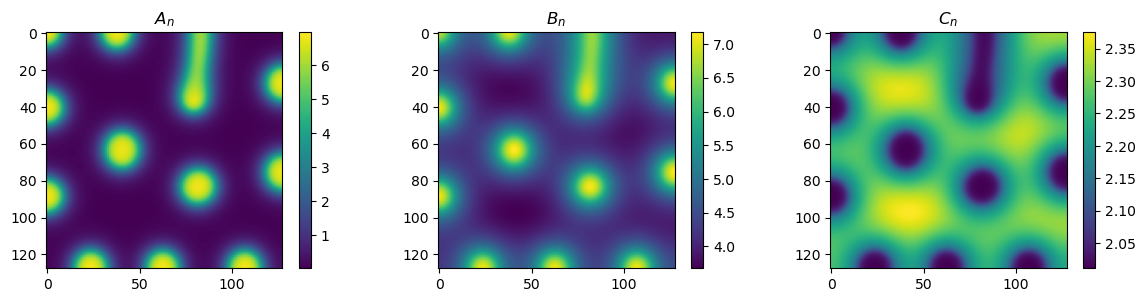

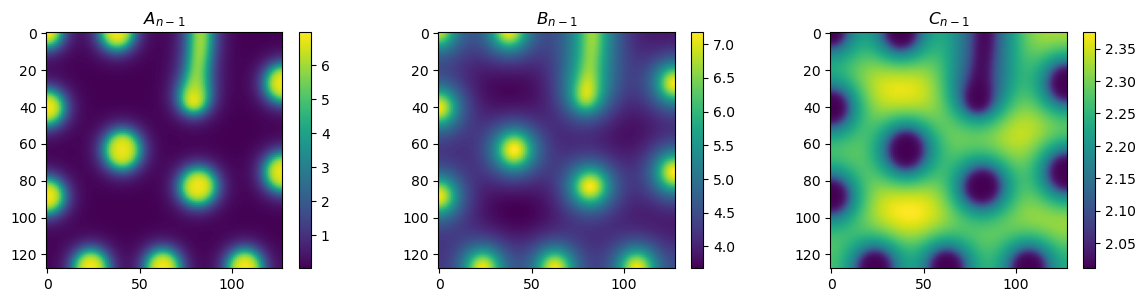

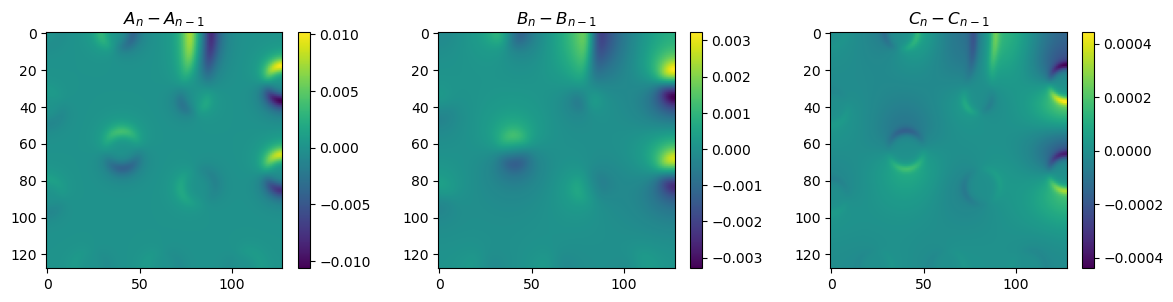

In [51]:
A_n = to(solution[-1, 0, :])
B_n = to(solution[-1, 1, :])
C_n = to(solution[-1, 2, :])

A_n_1 = to(solution[-2, 0, :])
B_n_1 = to(solution[-2, 1, :])
C_n_1 = to(solution[-2, 2, :])

plot_n_im([A_n, B_n, C_n], 
          [r"$A_{n}$", r"$B_{n}$", r"$C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([A_n_1, B_n_1, C_n_1], 
          [r"$A_{n-1}$", r"$B_{n-1}$", r"$C_{n-1}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A_n-A_n_1, B_n-B_n_1, C_n-C_n_1], 
          [r"$A_{n}-A_{n-1}$", r"$B_{n}-B_{n-1}$", r"$C_{n}-C_{n-1}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

## Check the identifiability of the solution for different thresholds

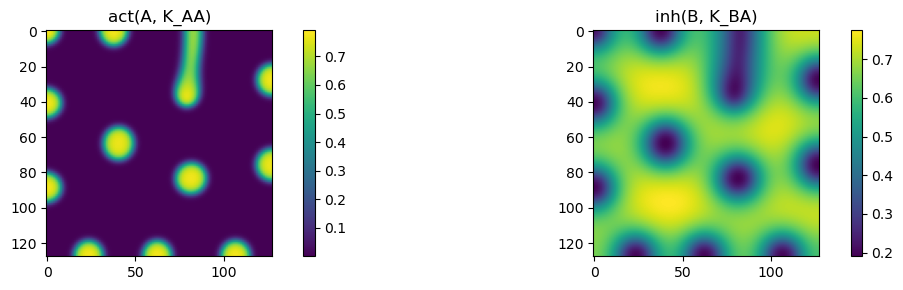

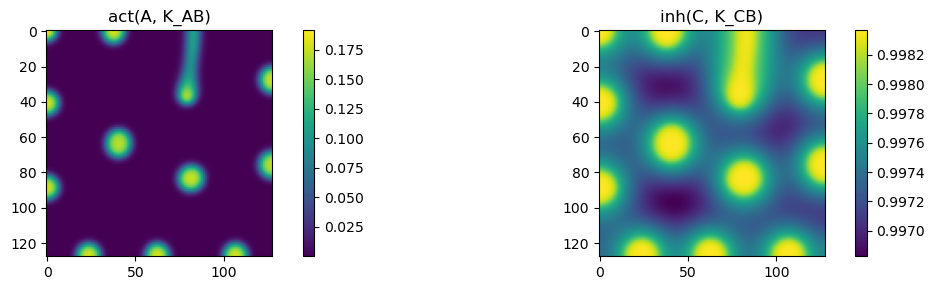

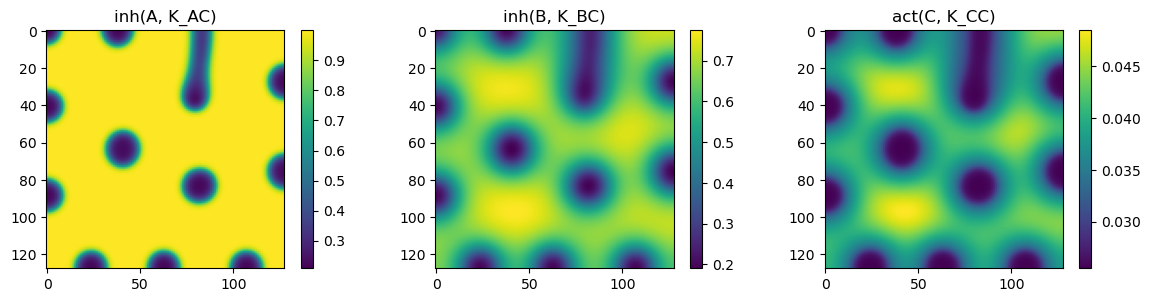

In [52]:
def act(x, km, n=2):
    return x**n / (x**n + km**n)

def inh(x, km, n=2):
    return 1 / (1 + (x / (km + 1e-16)) ** (n))

(D_A, D_B, 
b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C,
K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC, n) = (params["D_A"], params["D_B"], 
                                               params["b_A"], params["b_B"], params["b_C"], 
                                               params["V_A"], params["V_B"], params["V_C"],
                                               params["mu_A"], params["mu_B"], params["mu_C"],
                                               params["K_AA"], params["K_AB"], params["K_AC"],
                                               params["K_BA"], params["K_BC"], 
                                               params["K_CB"], params["K_CC"],
                                               params["n"])


plot_n_im([act(A_n, K_AA, n), inh(B_n, K_BA, n)], 
          [r"act(A, K_AA)", r"inh(B, K_BA)"],
          figsize=(12, 3)); plt.tight_layout();plt.show() 
plot_n_im([act(A_n, K_AB, n), inh(C_n, K_CB, n)], 
          [r"act(A, K_AB)", r"inh(C, K_CB)"],
          figsize=(12, 3)); plt.tight_layout();plt.show() 
plot_n_im([inh(A_n, K_AC, n), inh(B_n, K_BC, n), act(C_n, K_CC, n)], 
          [r"inh(A, K_AC)", r"inh(B, K_BC)", r"act(C, K_CC)"],
          figsize=(12, 3)); plt.tight_layout();plt.show() 

In [53]:
Adj_001, *_ = creat_topology(params, kinetics, A_n, B_n, C_n, threshold = 0.001)
Adj_01, *_ = creat_topology(params, kinetics, A_n, B_n, C_n, threshold = 0.01)

### $K_{CB}$ becomes ONE for 0.01

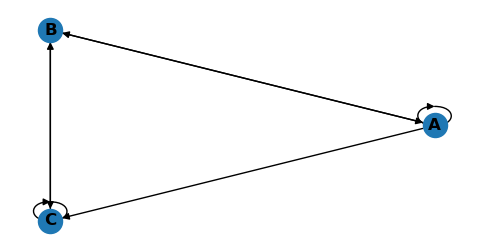

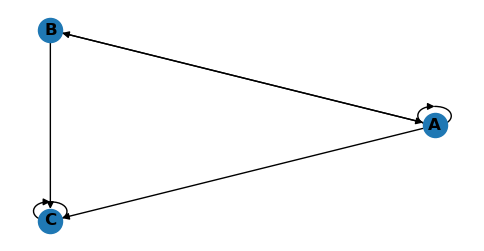

In [54]:
_ = plot_net(Adj_001),plot_net(Adj_01),

# Check the loss landscape

In [55]:
def create_Circuit_3954_L2(A, B, C, D_A, D_B, n, L=10):
    delta_steps = A.shape[0]*A.shape[1]/(L**2) 
    laplacian_A = D_A*delta_steps*grad_diff(A)[1:-1, 1:-1]
    laplacian_B = D_B*delta_steps*grad_diff(B)[1:-1, 1:-1]
    A = A[1:-1, 1:-1]
    B = B[1:-1, 1:-1]
    C = C[1:-1, 1:-1]
    def Circuit_3954_L2(b_A, mu_A, V_A, K_AA, K_AB, K_AC,
                        b_B, mu_B, V_B, K_BA, K_BC,
                        b_C, mu_C, V_C, K_CB, K_CC):
        F_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A    
        F_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B        
        F_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
        
        
        loss_A = np.mean((laplacian_A + F_A)**2)
        loss_B = np.mean((laplacian_B + F_B)**2)
        loss_C = np.mean(F_C**2)
        
        return loss_A + loss_B + loss_C
    return Circuit_3954_L2

In [56]:
Circuit_3954_L2 = create_Circuit_3954_L2(A_n, B_n, C_n, params["D_A"], params["D_B"], params["n"])

In [ ]:
params_ndarray = np.array([params["b_A"], params["mu_A"], params["V_A"],
                             params["K_AA"], params["K_AB"], params["K_AC"],
                             params["b_B"], params["mu_B"], params["V_B"],
                             params["K_AB"], params["K_BC"], 
                             params["b_C"],  params["mu_C"], params["V_C"], 
                             params["K_CB"], params["K_CC"]])
L2_samples, point_samples = MCMC(params_ndarray, Circuit_3954_L2, max_steps = 1000000)

# Make sure the chain is well-mixed, and find the burn-out size

In [ ]:
plt.figure(figsize=(10,4));plt.subplot(121)
plt.plot(L2_samples);plt.grid();plt.subplot(122)
plt.plot(L2_samples[100:]);plt.grid();plt.yscale('log');plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit(point_samples[100:, :])

In [ ]:
plot_minimums(params_ndarray, Circuit_3954_L2, pca, per_plot=4, y_scale='log')

In [ ]:
plot_minimums(params_ndarray, Circuit_3954_L2, pca, per_plot=1, y_scale='linear', steps = np.linspace(-10, 10, 2000))

# Find a good starting guess

In [ ]:
# five steps from the minimum in the direction of eigenvalue 6
init_params = directional_linspace(params_ndarray, pca.components_[8], np.linspace(0, 5, 2))[1]
(b_A, mu_A, V_A, K_AA, K_AB, K_AC,
 b_B, mu_B, V_B, K_BA, K_BC,
 b_C, mu_C, V_C, K_CB, K_CC) = init_params
init_params = {'b_A':b_A, 'mu_A':mu_A, 'V_A':V_A, 
               'K_AA':K_AA, 'K_AB':K_AB, 'K_AC':K_AC,
               'b_B':b_B, 'mu_B':mu_B, 'V_B':V_B, 
               'K_BA':K_BA, 'K_BC':K_BC,
               'b_C':b_C, 'mu_C':mu_C, 'V_C':V_C, 
               'K_CB':K_CB, 'K_CC':K_CC}

# Save the result, including the initial condition

In [58]:
solution_saved = np.vstack([np.stack([to(A_init), to(B_init), to(C_init)])[np.newaxis, ...], 
                            solution.reshape((-1, 3, 128, 128))])

In [59]:
solution_saved.shape

(101, 3, 128, 128)

In [60]:
import pickle

run_params = {'Lx':model_128_10.Lx,
              'Ly':model_128_10.Ly,
              'Ix':model_128_10.Ix,
              'Jy':model_128_10.Jy,
              'delta_t':model_128_10.Δt,
              'snpashots_t': 100,
              'solution_T_len': 101,
             }
with open(f"./outputs/solution_1.pkl", "wb") as f:
    pickle.dump((run_params, params, solution_saved), f)

In [ ]:
with open(f"./outputs/solution_1_L2_point_samples.npy", "wb") as f:
    np.save(f, point_samples)


In [ ]:
with open(f"./outputs/solution_1_init_params.pkl", "wb") as f:
    pickle.dump(init_params, f)

# Compare the estimated parameters from different methods

In [62]:
with open(f"./outputs/model_LBFGS_Field_only_estimated_params.pkl", "rb") as f:
    _, params_LBFG_field = pickle.load(f)
        
with open(f"./outputs/model_LBFGS_Field_only_non_stationary_estimated_params.pkl", "rb") as f:
    _, params_LBFG_field_non_state = pickle.load(f) 
    
with open(f"./outputs/model_LBFGS_Field_only_non_stationary_avg_mesh_estimated_params.pkl", "rb") as f:
    _, params_LBFG_field_non_state_avg_mesh = pickle.load(f) 
    
with open(f"./outputs/model_LBFGS_Field_only_non_stationary_LoG_estimated_params.pkl", "rb") as f:
    _, params_LBFG_field_non_state_LoG = pickle.load(f)  
    
with open(f"./outputs/model_LBFGS_Field_only_non_stationary_noisy_5_estimated_params.pkl", "rb") as f:
    _, params_LBFG_field_non_state_noisy_5 = pickle.load(f)      

In [63]:
mu_c_val= params["mu_C"]
def to_ndarray(params):
    return np.array([params["b_A"], params["mu_A"], params["V_A"],
                             params["K_AA"], params["K_AB"], params["K_AC"],
                             params["b_B"], params["mu_B"], params["V_B"],
                             params["K_AB"], params["K_BC"], 
                             params["b_C"],  mu_c_val, params["V_C"], 
                             params["K_CB"], params["K_CC"]])

params_original_arr = to_ndarray(params)
params_LBFG_field_arr = to_ndarray(params_LBFG_field)
params_LBFG_field_non_state_arr = to_ndarray(params_LBFG_field_non_state)
params_LBFG_field_non_state_avg_mesh_arr = to_ndarray(params_LBFG_field_non_state_avg_mesh)
params_LBFG_field_non_state_LoG_arr = to_ndarray(params_LBFG_field_non_state_LoG)
params_LBFG_field_non_state_noisy_5_arr = to_ndarray(params_LBFG_field_non_state_noisy_5)

In [68]:
print("field only - distance:",np.linalg.norm(params_LBFG_field_arr- params_original_arr), "L2:", Circuit_3954_L2(*params_LBFG_field_arr))
print("non-stationary field only - distance:",np.linalg.norm(params_LBFG_field_non_state_arr- params_original_arr),  "L2:",Circuit_3954_L2(*params_LBFG_field_non_state_arr))
print("non-stationary field only avg mesh - distance:",np.linalg.norm(params_LBFG_field_non_state_avg_mesh_arr- params_original_arr),  "L2:",Circuit_3954_L2(*params_LBFG_field_non_state_avg_mesh_arr))
print("non-stationary field only LoG - distance:",np.linalg.norm(params_LBFG_field_non_state_LoG_arr- params_original_arr),  "L2:",Circuit_3954_L2(*params_LBFG_field_non_state_LoG_arr))
print("non-stationary field only Noisy 5 - distance:",np.linalg.norm(params_LBFG_field_non_state_noisy_5_arr- params_original_arr),  "L2:",Circuit_3954_L2(*params_LBFG_field_non_state_noisy_5_arr))
print()

field only - distance: 117122.10089343674 L2: 123.57115492913859
non-stationary field only - distance: 49.97933550985723 L2: 126.31651236829119
non-stationary field only avg mesh - distance: 22469488.712065242 L2: 123.5239450231924
non-stationary field only LoG - distance: 67.17903901977103 L2: 126.5775132614318
non-stationary field only Noisy 5 - distance: 100.66018690972678 L2: 125.28000618101422



In [70]:
mu_c_val= params["mu_C"]
n = params["n"]
def creat_kinetics(params):
    return create_circuit_3954(n ,params["b_A"], params["mu_A"], params["V_A"], 
                               params["K_AA"], params["K_AB"], params["K_AC"],
                               params["b_B"], params["mu_B"], params["V_B"], 
                               params["K_BA"], params["K_BC"],
                               params["b_C"], mu_c_val, params["V_C"], 
                               params["K_CB"], params["K_CC"])
kinetics = creat_kinetics(params)
kinetics_LBFG_field = creat_kinetics(params_LBFG_field)
kinetics_LBFG_field_non_state = creat_kinetics(params_LBFG_field_non_state)
kinetics_LBFG_field_non_state_avg_mesh = creat_kinetics(params_LBFG_field_non_state_avg_mesh)
kinetics_LBFG_field_non_state_LoG = creat_kinetics(params_LBFG_field_non_state_LoG)
kinetics_LBFG_field_non_state_noisy_5 = creat_kinetics(params_LBFG_field_non_state_noisy_5)

In [ ]:
# solution_LBFG = model_128_10.integrate([A_init.flatten(), 
#                                        B_init.flatten(), 
#                                         C_init.flatten()],kinetics_LBFG, 100*5000, record_steps=5000)

In [71]:
solution_LBFG_field = model_128_10.integrate([A_init.flatten(), 
                                        B_init.flatten(), 
                                        C_init.flatten()],kinetics_LBFG_field, 100*5000, record_steps=5000)

In [72]:
# solution_LBFG_non_state = model_128_10.integrate([A_init.flatten(), 
#                                         B_init.flatten(), 
#                                         C_init.flatten()],kinetics_LBFG_non_state, 100*5000, record_steps=5000)

In [73]:
solution_LBFG_field_non_state = model_128_10.integrate([A_init.flatten(), 
                                        B_init.flatten(), 
                                        C_init.flatten()],kinetics_LBFG_field_non_state, 100*5000, record_steps=5000)

In [74]:
solution_LBFG_field_non_state_avg_mesh = model_128_10.integrate([A_init.flatten(), 
                                                                 B_init.flatten(), 
                                                                 C_init.flatten()],
                                                                kinetics_LBFG_field_non_state_avg_mesh,
                                                                100*5000, record_steps=5000)

In [75]:
solution_LBFG_field_non_state_LoG = model_128_10.integrate([A_init.flatten(), 
                                                            B_init.flatten(), 
                                                            C_init.flatten()],
                                                            kinetics_LBFG_field_non_state_LoG,
                                                            100*5000, record_steps=5000)

In [76]:
solution_LBFG_field_non_state_noisy_5 = model_128_10.integrate([A_init.flatten(), 
                                                            B_init.flatten(), 
                                                            C_init.flatten()],
                                                            kinetics_LBFG_field_non_state_noisy_5,
                                                            100*5000, record_steps=5000)

In [77]:
def get_parts(solution):
    return to(solution[-1, 0, :]), to(solution[-1, 1, :]), to(solution[-1, 2, :])

# A_n_LBFG, B_n_LBFG, C_n_LBFG = get_parts(solution_LBFG)
A_n_LBFG_field, B_n_LBFG_field, C_n_LBFG_field = get_parts(solution_LBFG_field)
# A_n_LBFG_non_state, B_n_LBFG_non_state, C_n_LBFG_non_state = get_parts(solution_LBFG_non_state)
A_n_LBFG_field_non_state, B_n_LBFG_field_non_state, C_n_LBFG_field_non_state = get_parts(solution_LBFG_field_non_state)
A_n_LBFG_field_non_state_avg_mesh, B_n_LBFG_field_non_state_avg_mesh, C_n_LBFG_field_non_state_avg_mesh = get_parts(
                                                   solution_LBFG_field_non_state_avg_mesh)
A_n_LBFG_field_non_state_LoG, B_n_LBFG_field_non_state_LoG, C_n_LBFG_field_non_state_LoG = get_parts(
                                                   solution_LBFG_field_non_state_LoG)
A_n_LBFG_field_non_state_noisy_5, B_n_LBFG_field_non_state_noisy_5, C_n_LBFG_field_non_state_noisy_5 = get_parts(
                                                   solution_LBFG_field_non_state_noisy_5)

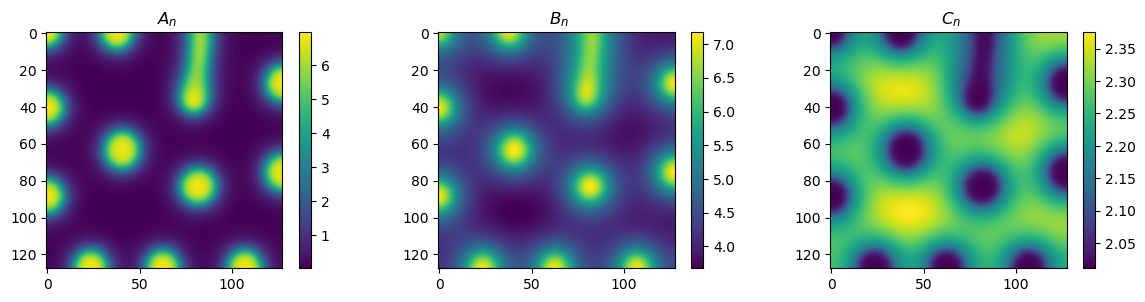

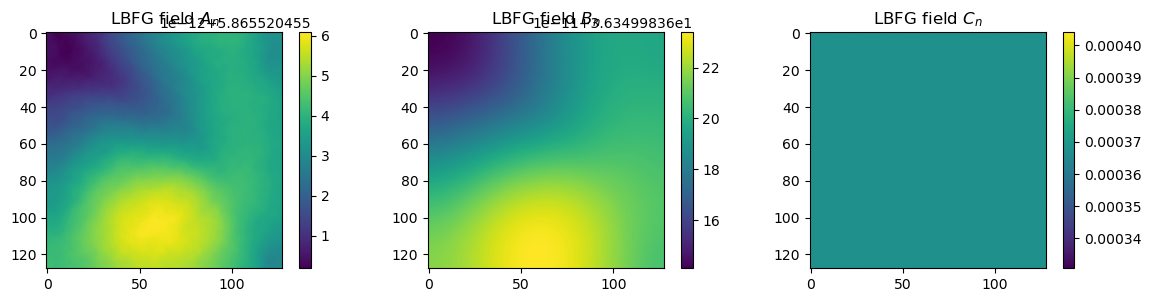

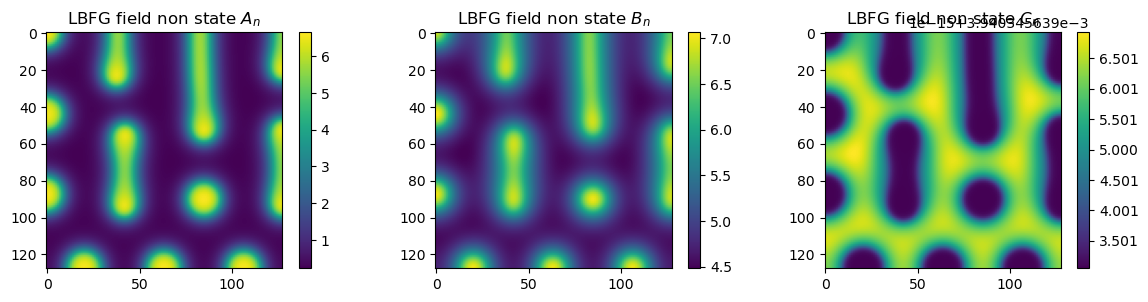

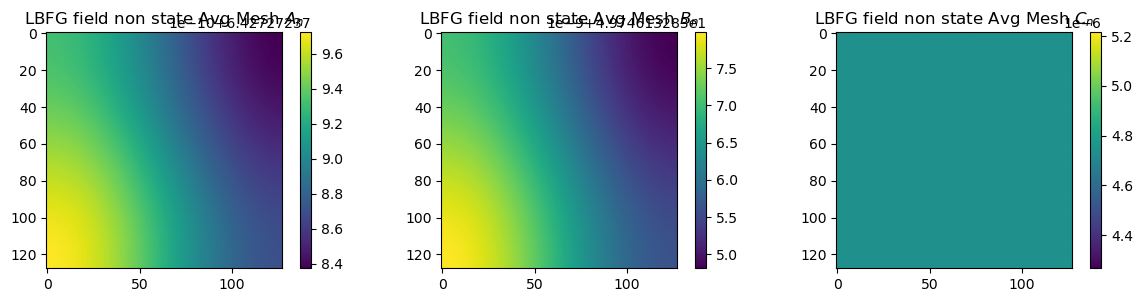

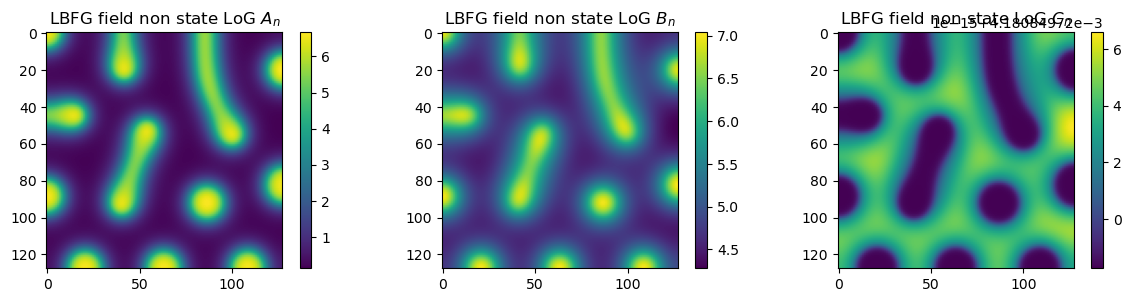

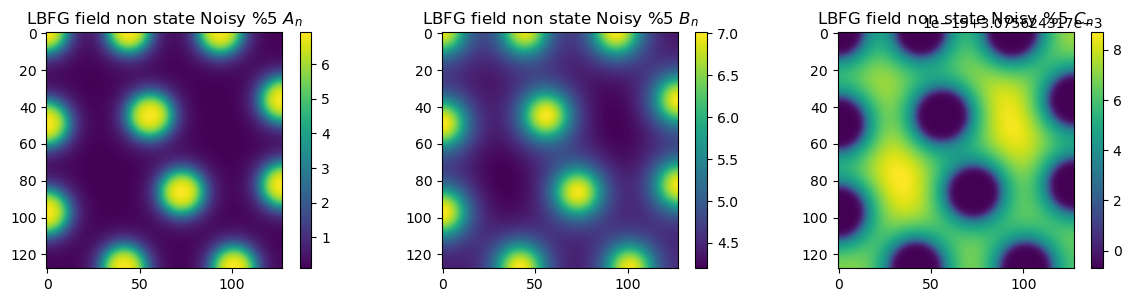

In [78]:
def plot(A_n, B_n, C_n, prefix=""):
    plot_n_im([A_n, B_n, C_n], 
          [f"{prefix} " r"$A_{n}$", f"{prefix} " r"$B_{n}$", f"{prefix} " r"$C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot(A_n, B_n, C_n, prefix="")
# plot(A_n_LBFG, B_n_LBFG, C_n_LBFG, prefix="LBFG")
plot(A_n_LBFG_field, B_n_LBFG_field, C_n_LBFG_field, prefix="LBFG field")
# plot(A_n_LBFG_non_state, B_n_LBFG_non_state, C_n_LBFG_non_state, prefix="LBFG non state")
plot(A_n_LBFG_field_non_state, B_n_LBFG_field_non_state, C_n_LBFG_field_non_state, prefix="LBFG field non state")
plot(A_n_LBFG_field_non_state_avg_mesh, B_n_LBFG_field_non_state_avg_mesh, C_n_LBFG_field_non_state_avg_mesh,
     prefix="LBFG field non state Avg Mesh")
plot(A_n_LBFG_field_non_state_LoG, B_n_LBFG_field_non_state_LoG, C_n_LBFG_field_non_state_LoG,
     prefix="LBFG field non state LoG")
plot(A_n_LBFG_field_non_state_noisy_5, B_n_LBFG_field_non_state_noisy_5, C_n_LBFG_field_non_state_noisy_5,
     prefix="LBFG field non state Noisy %5")

In [79]:
names = ["b_A","mu_A","V_A","K_AA","K_AB","K_AC","b_B","mu_B","V_B","K_BA","K_BC","b_C","mu_C","V_C","K_CB","K_CC"]

all_together= zip(names, params_original_arr, params_LBFG_arr, params_LBFG_field_arr, params_LBFG_non_state_arr, params_LBFG_field_arr)
print("name \t Ref \t\tLBFG \t\t\t Field \t\t\tNon-Stat\t\tField Non-Stat")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{o:.3f}\t\t"
                  f"{LBFG:.3f}/{np.abs(o-LBFG):.3f}\t\t"
                  f"{field:.3f}/{np.abs(o-field):.3f}\t\t"
                  f"{no_stat:.3f}/{np.abs(o-no_stat):.3f}\t\t"
                  f"{field_no_stat:.3f}/{np.abs(o-field_no_stat):.3f}\t\t"
    for name, o,LBFG, field, no_stat, field_no_stat in all_together
]))

NameError: name 'params_LBFG_arr' is not defined

In [ ]:
# Circuit_3954_L2_good = create_Circuit_3954_L2(A_n_good, B_n_good, C_n_good, params["D_A"], params["D_B"], params["n"])
# Circuit_3954_L2_bad = create_Circuit_3954_L2(A_n_bad, B_n_bad, C_n_bad, params["D_A"], params["D_B"], params["n"])

In [ ]:
# print(np.linalg.norm(params_ndarray-params_good_ndarray), Circuit_3954_L2_good(*params_good_ndarray))
# print(np.linalg.norm(params_ndarray- params_bad_ndarray), Circuit_3954_L2_bad(*params_bad_ndarray))
# print(np.linalg.norm(params_bad_ndarray- params_good_ndarray))

In [ ]:
# print(rmse(A_n,A_n_good), rmse(B_n,B_n_good), rmse(C_n,C_n_good))
# print(rmse(A_n,A_n_good)/np.mean(A_n), rmse(B_n,B_n_good)/np.mean(B_n), rmse(C_n,C_n_good)/np.mean(C_n))
# print(np.mean(A_n), np.mean(A_n_good), np.mean(B_n),np.mean(B_n_good), np.mean(C_n), np.mean(C_n_good))
# print()
# print(rmse(A_n,A_n_bad), rmse(B_n,B_n_bad), rmse(C_n,C_n_bad))
# print(rmse(A_n,A_n_bad)/np.mean(A_n), rmse(B_n,B_n_bad)/np.mean(B_n), rmse(C_n,C_n_bad)/np.mean(C_n))
# print(np.mean(A_n), np.mean(A_n_bad), np.mean(B_n),np.mean(B_n_bad), np.mean(C_n), np.mean(C_n_bad))

In [ ]:
# print(np.linalg.norm(params_ndarray-e3_ndarray), Circuit_3954_L2(*e3_ndarray))